# Modeling elections

In [17]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan

## Data

The `electoral_votes` variable is a dictionary containing the number of Electoral College votes for each state. For example
```
  >>> electoral_votes['Indiana']
  11
```
Data from [Wikipedia: United_States_Electoral_College](https://en.wikipedia.org/wiki/United_States_Electoral_College)

The `survey_results` variable is a dictionary mapping from states to an array of survey results for each candidate. Each row in a survey results array represents one survey and each column represents one candidate. There are 3 columns, representing Trump (Republican), Biden (Democrat), and Other in that order. In the example below, Trump got 340 votes in the first survey, Biden got 258, and Other got 40.
```
  >>> survey_results['Indiana']
  array([[340, 258,  40],
         [240, 155,  10],
         [235, 155,  70],
         [308, 266,  84],
         [222, 161, 110]])
```
Data from [Wikipedia: Statewide opinion polling for the 2020 United States presidential election](https://en.wikipedia.org/wiki/Statewide_opinion_polling_for_the_2020_United_States_presidential_election)


In [18]:
electoral_votes = {
    'Alabama': 9,
    'Alaska': 3,
    'Arizona': 11,
    'Arkansas': 6,
    'Colorado': 9,
}

survey_results = {
    'Alabama': np.array([[611, 397, 0, 0], [799, 528, 0, 0], [793, 403, 0, 0], [288, 264, 0, 0], [353, 219, 0, 0], [997, 554, 0, 0], [312, 232, 0, 0], [409, 227, 0, 0], [319, 234, 0, 0]]),
    'Alaska': np.array([[348, 320, 0, 0], [298, 253, 0, 0], [283, 277, 0, 0], [269, 198, 0, 0], [227, 177, 0, 0], [442, 389, 0, 0], [519, 486, 0, 0], [325, 318, 0, 0], [84, 74, 0, 0]]),
    'Arizona': np.array([[522, 478, 22, 0], [313, 356, 7, 7], [291, 304, 0, 0], [270, 288, 0, 0], [236, 264, 16, 0], [180, 184, 0, 0], [133, 151, 0, 0], [269, 321, 20, 0], [230, 250, 5, 0], [3337, 3621, 0, 0], [360, 392, 0, 0], [235, 235, 0, 0], [364, 396, 8, 0], [383, 409, 9, 9], [221, 216, 0, 0], [113, 128, 0, 0], [284, 278, 0, 0], [168, 212, 0, 0], [258, 270, 0, 0], [260, 266, 0, 0], [359, 402, 9, 0], [185, 202, 17, 0], [261, 320, 26, 0], [519, 584, 0, 0], [328, 342, 0, 0], [487, 520, 0, 0], [252, 312, 0, 0], [752, 768, 0, 0], [414, 441, 0, 0], [212, 230, 0, 0], [357, 398, 0, 8], [309, 378, 23, 0], [3357, 3034, 0, 0], [396, 490, 0, 0], [162, 169, 0, 0], [325, 402, 9, 9], [445, 426, 0, 0], [311, 350, 0, 0], [188, 193, 0, 0], [466, 456, 30, 0], [271, 295, 0, 0], [204, 192, 0, 0], [522, 547, 24, 12], [2547, 2348, 0, 0], [164, 172, 0, 0], [381, 445, 0, 0], [393, 428, 0, 0], [326, 395, 17, 9], [372, 413, 0, 0], [432, 470, 0, 0], [315, 343, 0, 0], [155, 176, 0, 0], [500, 500, 0, 0], [264, 294, 0, 0], [1230, 1088, 0, 0], [270, 282, 0, 0], [137, 159, 0, 0], [258, 237, 0, 0], [337, 372, 17, 9], [266, 312, 0, 0], [616, 670, 0, 0], [88, 90, 0, 0], [421, 461, 0, 0], [148, 145, 0, 0], [368, 353, 0, 0], [180, 188, 0, 0], [388, 426, 0, 0], [258, 300, 0, 0], [230, 235, 0, 0], [258, 312, 0, 0]]),
    'Arkansas': np.array([[478, 293, 0, 0], [462, 220, 0, 0], [493, 239, 0, 0], [209, 135, 0, 0], [408, 391, 0, 0]]),
    'Colorado': np.array([[408, 510, 0, 0], [1114, 1549, 0, 0], [283, 322, 0, 0], [320, 400, 0, 0], [312, 400, 32, 8], [978, 1359, 0, 0], [262, 325, 0, 0], [252, 306, 0, 0], [246, 307, 0, 0], [246, 306, 0, 0], [240, 312, 0, 0], [935, 1355, 0, 0], [240, 320, 0, 0], [246, 306, 0, 0], [365, 481, 0, 0], [328, 470, 0, 0], [457, 620, 0, 0], [240, 286, 0, 0], [280, 371, 0, 0], [216, 330, 0, 0], [133, 201, 0, 0]]),
}

for key, value in survey_results.items():
    survey_results[key] = np.concatenate((value[:,:2], value[:,2:3] + value[:,3:4]), axis=1)

states = sorted(survey_results.keys())
print('Modeling', len(states), 'states with', sum(electoral_votes[s] for s in states), 'electoral college votes')

Modeling 5 states with 38 electoral college votes


## Generative model

1. For each state we generate an $\vec{\alpha}$ vector, which defines a Dirichlet distribution over the proportion of votes that go to each of the 3 candidates whenever we do a survey – including the final survey, namely the election itself which we want to predict. The prior over each component of $\vec{\alpha}$ is taken as a Cauchy distribution with location 0 and scale 1. Since the components of $\vec{\alpha}$ are positive, we actually use the positive half-Cauchy distribution.

2. For each survey in a state we generate a probability vector $\vec{p_i} \sim \text{Dirichlet}(\vec{\alpha})$ for the probability that a voter selects each of the 3 candidates.

3. For each survey, we then generate the number of votes going to each candidate as $\vec{k_i} \sim \text{Multinomial}(\vec{p_i})$.

### Tasks

* Use Stan to sample from the posterior distribution over $\alpha$ and visualize your results. There are 5 states, so you will have 5 posteriors.
* The posteriors over $\alpha$ show a lot of variation between different states. Explain the results you get in terms of the model and the data.

In [19]:
stan_code = '''
// known values
data {
    int<lower=1> n_surveys; // amount of surveys
    int<lower=1> n_candidates; // amount of candidates
    int<lower=0> survey_results[n_surveys, n_candidates]; // result for a candidate in a survey
    real cauchy_location; // prior hyperparameter for half-cauchy over alpha
    real cauchy_scale; // prior hyperparameter for half-cauchy over alpha
}

//unknown values
parameters {
    vector<lower=0>[n_candidates] alpha; // prior for the distribution
    simplex[n_candidates] p[n_surveys]; // probability vector for each survey, probability of winning
}

model {
    alpha ~ cauchy(cauchy_location, cauchy_scale);
    for (i in 1:n_surveys){
        p[i] ~ dirichlet(alpha); // the probability that a voter selects each of the 3 candidates
        survey_results[i] ~ multinomial(p[i]); // k
    }
        
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67fc1997df9eef78d06869db50361dcc NOW.


Inference for Stan model: anon_model_67fc1997df9eef78d06869db50361dcc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
alpha[1]  70.62     1.6   48.1   12.8   58.1 195.25    901    1.0
alpha[2]   45.8    1.03  30.82    8.5   37.9 127.78    896    1.0
alpha[3]   0.12  2.4e-3   0.06   0.04   0.11   0.27    630    1.0
p[1,1]     0.61  3.5e-4   0.01   0.58   0.61   0.64   1818    1.0
p[2,1]      0.6  3.0e-4   0.01   0.58    0.6   0.63   1844    1.0
p[3,1]     0.66  3.8e-4   0.01   0.63   0.66   0.68   1267    1.0
p[4,1]     0.54  5.5e-4   0.02   0.49   0.54   0.58   1554    1.0
p[5,1]     0.62  4.2e-4   0.02   0.58   0.62   0.65   2064    1.0
p[6,1]     0.64  2.9e-4   0.01   0.62   0.64   0.66   1742    1.0
p[7,1]     0.58  4.8e-4   0.02   0.54   0.58   0.62   1725    1.0
p[8,1]     0.64  5.0e-4   0.02    0.6   0.64   0.67   1243    1.0
p[9,1]     0.58  4.

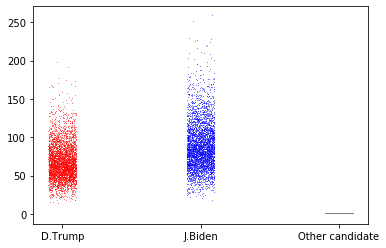

Inference for Stan model: anon_model_67fc1997df9eef78d06869db50361dcc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
alpha[1] 301.37   19.15 248.34  37.91 227.85 863.42    168   1.03
alpha[2]  266.7   17.08  218.7  32.63 199.59 767.28    164   1.03
alpha[3]   0.22    0.01   0.17   0.05   0.16   0.71    198   1.02
p[1,1]     0.52  3.7e-4   0.02   0.49   0.52   0.56   1830    1.0
p[2,1]     0.54  3.8e-4   0.02    0.5   0.54   0.57   1903    1.0
p[3,1]     0.52  5.1e-4   0.02   0.48   0.52   0.55   1208    1.0
p[4,1]     0.55  5.8e-4   0.02   0.52   0.55    0.6   1124    1.0
p[5,1]     0.55  4.7e-4   0.02   0.51   0.54   0.59   1665    1.0
p[6,1]     0.53  3.1e-4   0.01    0.5   0.53   0.56   2098    1.0
p[7,1]     0.52  3.5e-4   0.01   0.49   0.52   0.55   1472    1.0
p[8,1]     0.52  4.0e-4   0.02   0.48   0.52   0.55   1620    1.0
p[9,1]     0.53  4.

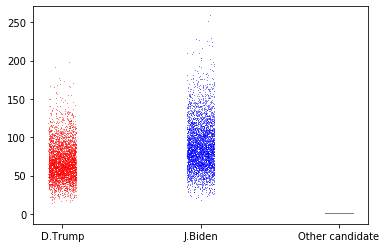

Inference for Stan model: anon_model_67fc1997df9eef78d06869db50361dcc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
alpha[1]  43.42     0.2   7.39  30.64  42.77  59.53   1307    1.0
alpha[2]  46.52    0.22   7.89  32.88   45.9  63.82   1299    1.0
alpha[3]   0.19  2.0e-3   0.04   0.13   0.19   0.29    466    1.0
p[1,1]     0.51  2.9e-4   0.01   0.48   0.51   0.54   2639    1.0
p[2,1]     0.46  3.5e-4   0.02   0.42   0.46    0.5   2811    1.0
p[3,1]     0.49  3.8e-4   0.02   0.45   0.49   0.53   2508    1.0
p[4,1]     0.48  3.5e-4   0.02   0.45   0.48   0.52   3344    1.0
p[5,1]     0.46  4.1e-4   0.02   0.42   0.46    0.5   2427    1.0
p[6,1]     0.49  4.1e-4   0.02   0.45   0.49   0.54   3193    1.0
p[7,1]     0.47  5.2e-4   0.03   0.42   0.47   0.52   2745    1.0
p[8,1]     0.45  3.1e-4   0.02   0.41   0.45   0.48   3455    1.0
p[9,1]     0.47  4.

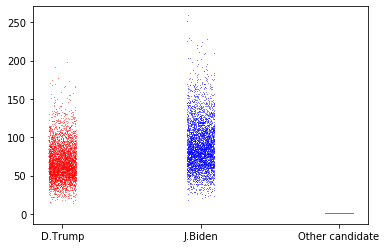

Inference for Stan model: anon_model_67fc1997df9eef78d06869db50361dcc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
alpha[1]  15.95     0.9  17.65   1.64  10.25  60.82    385   1.02
alpha[2]   9.87    0.53  10.65   1.09   6.48  37.44    408   1.02
alpha[3]   0.11  2.2e-3   0.06   0.03    0.1   0.27    797    1.0
p[1,1]     0.62  4.3e-4   0.02   0.59   0.62   0.66   1664    1.0
p[2,1]     0.68  3.8e-4   0.02   0.64   0.68   0.71   2147    1.0
p[3,1]     0.67  4.2e-4   0.02   0.64   0.67    0.7   1655    1.0
p[4,1]     0.61  6.3e-4   0.03   0.56   0.61   0.66   1699    1.0
p[5,1]     0.51  4.0e-4   0.02   0.48   0.51   0.55   1986    1.0
p[1,2]     0.38  4.3e-4   0.02   0.34   0.38   0.41   1663    1.0
p[2,2]     0.32  3.8e-4   0.02   0.29   0.32   0.36   2153    1.0
p[3,2]     0.33  4.2e-4   0.02    0.3   0.33   0.36   1660    1.0
p[4,2]     0.39  6.

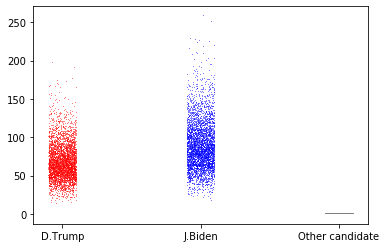

Inference for Stan model: anon_model_67fc1997df9eef78d06869db50361dcc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
alpha[1]  68.94    0.96  24.71  32.56   65.7  124.7    668    1.0
alpha[2]  90.39    1.26  32.54  43.26  85.84 166.32    670    1.0
alpha[3]   0.13  2.1e-3   0.05   0.07   0.12   0.25    487    1.0
p[1,1]     0.44  4.3e-4   0.01   0.41   0.44   0.47   1170    1.0
p[2,1]     0.42  2.5e-4 9.3e-3    0.4   0.42   0.44   1407    1.0
p[3,1]     0.46  6.0e-4   0.02   0.43   0.46    0.5    929    1.0
p[4,1]     0.44  5.3e-4   0.02   0.41   0.44   0.47   1008    1.0
p[5,1]     0.42  4.3e-4   0.02   0.39   0.42   0.45   1310    1.0
p[6,1]     0.42  3.4e-4   0.01    0.4   0.42   0.44    932   1.01
p[7,1]     0.44  6.0e-4   0.02   0.41   0.44   0.48    987    1.0
p[8,1]     0.45  4.9e-4   0.02   0.41   0.45   0.48   1337    1.0
p[9,1]     0.44  5.

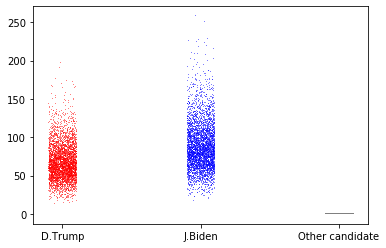

In [20]:
## empty disctionary for results
state_results = {}

## creating data for each state, plotting
for i in states:
    data = {
        'n_surveys': survey_results[i].shape[0],
        'n_candidates': 3,
        'survey_results': survey_results[i],
        'cauchy_location': 0, #hyperparameters
        'cauchy_scale': 1}
    ## saving the samples for each state
    state_results[i] = stan_model.sampling(data=data)
    ## extracting the samples
    #print(samples)
    print(state_results[i].stansummary(pars=['alpha','p'], probs=[0.025, 0.5, 0.975]))
    
    print("U.S. State:", i)
    print(np.percentile(samples['alpha'], [2.5, 97.5]))
    
    plt.figure(figsize=(6,4))
    colors = ["red", "blue", "grey"]
    # for 3 options
    for x in range(3):
        col = colors[x]
        plt.plot(sts.uniform.rvs(loc=x-0.1, scale=0.2, size=4000), samples['alpha'][:, x], ",", alpha=0.5, color=col)
    plt.xticks([0,1,2],['D.Trump', 'J.Biden', 'Other candidate'])
    plt.show()

## Simulation time

Use the posterior samples to predict the outcome of the presidential elections.

* Predict the probability that each candidate will win each state.
   * Use the posterior $\alpha$ samples to generate posterior predictive samples for $p$ – the proportion of votes each candidate would get in each state in an election.
   * Use these $p$ samples to estimate the probability that each candidate will win each state.
* Predict the probability that each candidate will win the presidential election.
   * Use the posterior predictive probability that each candidate will win each state to generate samples over the total number Electoral College votes each candidate would get in an election.
   * Use the total number of votes to generate samples over who would win the election.

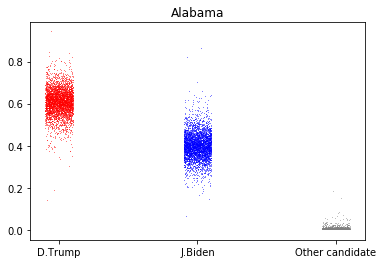

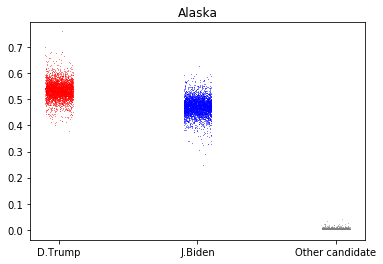

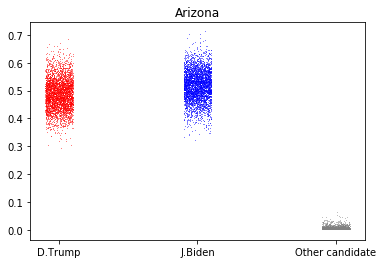

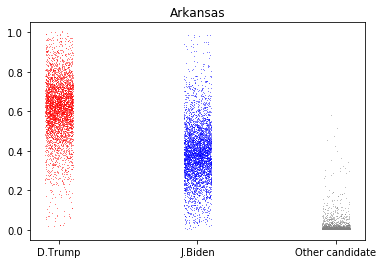

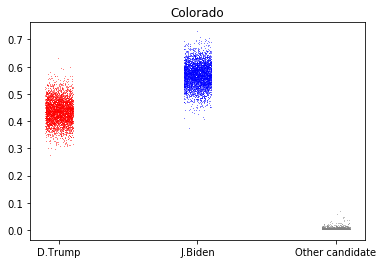

In [21]:
#(i)

for i in states:
    # all samples extract
    samples = state_results[i].extract()
    # posterior samples of a
    alpha = samples['alpha']
    # empty array for predicted posterior samples of a
    pred_p = np.empty(alpha.shape)
    rng = alpha.shape[0] #4000
    
    # posterior predictive samples
    for x in range(4000):
        pred_p[x] = sts.dirichlet.rvs(alpha[x])
    
    # plotting
    plt.figure(figsize=(6,4))
    
    colors = ["red", "blue", "grey"]
    for y in range(3):
        col = colors[y]
        plt.plot(sts.uniform.rvs(loc=y-0.1, scale=0.2, size=4000), pred_p[:,y], ',', alpha=0.5, color=col)
        plt.title(i)
        plt.xticks([0,1,2], ['D.Trump','J.Biden','Other candidate'])
    plt.show